# Homework 4 - Recommendation systems and clustering everywhere

#### Group 9 <br>

<div style="float: left;">
    <table>
        <tr>
            <th>Student</th>
            <th>GitHub</th>
            <th>Matricola</th>
            <th>E-Mail</th>
        </tr>
        <tr>
            <td>Erika Iona Zetu</td>
            <td>Erikazetu</td>
            <td>1888659</td>
            <td>zetu.1888659@studenti.uniroma1.it</td>
        </tr>
        <tr>
            <td>Matteo Pazzini</td>
            <td>matteopazzini</td>
            <td>1868953</td>
            <td>pazzini.1868953@studenti.uniroma1.it</td>
        </tr>
        <tr>
            <td>Francesco Sbordone</td>
            <td>Sbord1</td>
            <td>1969896</td>
            <td>sbordone.1969896@studenti.uniroma1.it</td>
        </tr>
        <tr>
            <td>André Leibrant</td>
            <td>JesterProphet</td>
            <td>2085698</td>
            <td>andre.leibrant@gmx.de</td>
        </tr>
    </table>
</div>

#### Import Libraries and Modules

In [41]:
from typing import List

from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

import functions

In [2]:
pd.set_option("display.max_colwidth", None)

## 1. Recommendation sytem
Implementing a recommendation system is critical for businesses and digital platforms that want to thrive in today's competitive environment. These systems use data-driven personalization to tailor content, products, and services to individual user preferences. The latter improves user engagement, satisfaction, retention, and revenue through increased sales and cross-selling opportunities. In this section, you will attempt to implement a recommendation system by identifying similar users' preferences and recommending movies they watch to the study user.

To be more specific, you will implement your version of the [LSH algorithm](https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/), which will take as input the user's preferred genre of movies, find the most similar users to this user, and recommend the most watched movies by those who are more similar to the user.

**Data:** The data you will be working with can be found [here](https://www.kaggle.com/datasets/vodclickstream/netflix-audience-behaviour-uk-movies).

Looking at the data, you can see that there is data available for each user for the movies the user <u>clicked on</u>. Gather the **title** and **genre** of the **maximum top 10 movies** that each user clicked on regarding the **number of clicks**.

---

First we are reading the data into a Pandas DataFrame. Then we do a little bit of preprocessing:
1. Droping the `row ID` column because we don't need it
2. Converting the `datatime` column to a date
3. Converting the `release_date` column to a date
4. Extracting the `genres` column to a new column `genre_list` that includes a list with all genres

In [3]:
# Read data into a Pandas DataFrame
dataset = pd.read_csv("vodclickstream_uk_movies_03.csv")

In [4]:
# Drop Row ID column
dataset.drop(dataset.columns[0], axis=1, inplace=True)

# Convert datetime column to a date
dataset.datetime = pd.to_datetime(dataset.datetime)

# Convert release_date column to a date
dataset.release_date = pd.to_datetime(dataset.release_date, errors="coerce")

# Extract genres column to a new column genre_list that includes a list with all genres
dataset["genre_list"] = dataset.genres.apply(lambda row: [word.strip() for word in row.split(",")])

In the next step we are defining a function `top_10_movies` that takes a `user_id` and extracts the top 10 most clicked movies by the user. For this we can easily group by the columns `user_id`, `movie_id`, `title`, and `genres` and create a new aggregation column called `clicks`. At the end we sort the column `clicks` in ascending order and return only the top 10 entries including only the desired columns.

In [5]:
def top_10_movies(user_id: str) -> pd.DataFrame:
    """
    Function that takes a user id and returns the top 10 most clicked movies by the user.

    Args:
        user_id (str): User ID.

    Returns:
        top_10_movies (pd.DataFrame): Pandas DataFrame that includes the top 10 most clicked movies by the user.
    """
    
    # Filter all movies for given user
    movies = dataset[dataset["user_id"] == user_id]

    # Extract the top 10 movies regarding the number of clicks for the given user
    movies = movies.groupby(["user_id", "movie_id", "title", "genres"]).size().reset_index(name="clicks")
    top_10_movies = movies.sort_values(by="clicks", ascending=False).head(10)[["title", "genres", "clicks"]]

    # Reset the index of the dataframe
    top_10_movies.reset_index(drop=True,inplace=True)
    
    return top_10_movies

This is an example output for the user `b15926c011`.

In [6]:
# Given user id
user_id = "b15926c011"

# Retrive top 10 movies of given user regarding the clicks
top_10_movies(user_id)

,title,genres,clicks
0,Wild Child,"Comedy, Drama, Romance",23
1,Zapped,"Comedy, Family, Fantasy",19
2,Barely Lethal,"Action, Comedy",18
3,#Horror,"Crime, Drama, Horror, Mystery, Thriller",16
4,Innocence,"Fantasy, Horror, Mystery, Romance, Thriller",13
5,You Get Me,"Crime, Drama, Romance, Thriller",12
6,Minor Details,"Adventure, Family, Mystery",12
7,The 5th Wave,"Action, Adventure, Sci-Fi, Thriller",10
8,IBOY,"Action, Crime, Sci-Fi, Thriller",10
9,Molly Moon and the Incredible Book of Hypnotism,"Adventure, Family, Fantasy",10


### 1.2 Minhash Signatures
Using the movie genre and user_ids, try to implement your min-hash signatures so that users with similar interests in a genre appear in the same bucket.

**Important note:** You must write your minhash function from scratch. You are not permitted to use any already implemented hash functions. Read the class materials and, if necessary, conduct an internet search. The description of hash functions in the [book](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf) may be helpful as a reference.

---

First we create a list `unique_genres` that includes the unique values of all genres across our data. We use the `capture` hint so that we suppress the output of the cell.

In [7]:
%%capture

# Retrieve a list with all unique genres
unique_genres = set()
dataset["genre_list"].apply(lambda row: [unique_genres.add(value) for value in row])

Based on this list we can create a new column `one_hot_genre_list` that includes only 0s and 1s which is at the end a binary representation of the genres of a movie where a 1 on the i-th position represents the genre in the i-th position in the `unique_genres` list.

In [8]:
# Encode the genre list (which we treat as our shingles) of every movie to a one-hot list
dataset["one_hot_genre_list"] = dataset["genre_list"].apply(
    lambda genre_list: [1 if genre in genre_list else 0 for genre in unique_genres]
)

In the next step we defined our minhash function in the following way: We decided on choosing a similarity signature based on 12 different hash functions, all defined in the function `hash_function` which takes the binary representation of the genres of a movie in `one_hot_genre_list` and returns the similarity signature. The modulo of all hash functions is based on the highest value the term before the modulo can take from which we then took the closest or seconds closest prime number (larger than the highest value the term before can take) to make our hash functions as precise as possible and avoid coellisions.

In [9]:
def hash_function(element: List) -> List:
    """
    Function that takes a list of integer numbers and returns all results based on 12 different hash functions.

    Args:
        element (List): List of integer numbers.

    Returns:
        hashes_result (List): Hash function results.
    """
    
    # Create an empty list of size 12
    hashes_result = [None]*12
    
    # Calculate every value of the values of the given list based on 12 different hash functions
    hashes_result[0] = (element + 1) % 29
    hashes_result[1] = (3*element + 1) % 83
    hashes_result[2] = (2*element + 4) % 59
    hashes_result[3] = (3*element - 1) % 83
    hashes_result[4] = (element << 1) % 59
    hashes_result[5] = (element >> 1) % 19
    hashes_result[6] = (element << 2) % 109
    hashes_result[7] = (element >> 2) % 11
    hashes_result[8] = (element << 3) % 211
    hashes_result[9] = (element >> 3) % 7
    hashes_result[10] = (element << 4) % 421
    hashes_result[11] = (element >> 4) % 5
    
    return hashes_result


def minhash(genre_list: List) -> List:
    """
    Function that takes a list of genres based on a binary representation and returns its minhash similarity
    signature.

    Args:
        genre_list (List): List of genres based on a binary representation.

    Returns:
        similarity_signature (List): Minhash Similarity Signature.
    """
    
    # Create list of size 12 and inf as the default value
    similarity_signature = [float("inf")]*12

    # Iterate through every element of the genre list
    for row_index, genre in enumerate(genre_list):
        
        # Calculate the hash values of the current genre and skip otherwise
        if genre == 1:
            
            # Retrieve hash values of current genre based on the row index
            hashes_result = hash_function(row_index)
            
            # Only update the similarity signature if a new hash value is smaller then the current one
            for i in range(0, 12):
                similarity_signature[i] = min(similarity_signature[i], hashes_result[i])

    return similarity_signature

Using `hash_function` we create a new column `minhash` transforming the binary representation in `one_hot_genre_list` to the similariy signature of every movie.

**Note:** We are decreasing from `n = len(unique_genres)` elements to 12!

In [10]:
# Create the minhash similarity signature for every movie
dataset["minhash"] = dataset["one_hot_genre_list"].apply(lambda genre_list: minhash(genre_list))

Finally we define with our own `custom_hash` function our LSH function `lsh` which transforms every similarity signature based on the given number of buckets `b` and number of rows `r` to the final band of hashes based on the same hash function on every bucket. The retrieved value we then divide by a very large prime number.

In [50]:
def custom_hash(bucket: List) -> int:
    """
    Function that takes a list with integer values and calculates one integer value from it.

    Args:
        bucket (List): Bucket from Similarity Signature.

    Returns:
        hash_value (int): Hash value from given bucket.
    """
    
    # Initilize hash value and prime number
    hash_value = 0
    prime_number = 41

    # Iterate through every value of the bucket
    for element in bucket:
        
        # Calculate hash value
        hash_value = (hash_value*prime_number) + element

    return hash_value


def lsh(similarity_signature: List, num_buckets: int, num_rows: int) -> List:
    """
    Function that transforms a taken similarity signature based on the given number of buckets and number of rows
    to the final band of hashes using the same hash function for every bucket.

    Args:
        similarity_signature (List): Minhash Similarity Signature.
        num_buckets(int): Number of buckets the Similarity Signature is devided in.
        num_rows(int): Number of rows every bucket has.

    Returns:
        band_hashes (List): Final band of hashes.
    """

    # Create empty list
    band_hashes = []

    # Iterate through every bucket
    for bucket_start in range(0, len(similarity_signature), num_rows):
        
        # Extract current bucket
        bucket = similarity_signature[bucket_start:bucket_start+num_rows]
        
        # Calculate band hash for current bucket
        band_hash = custom_hash(bucket) % 997
        
        # Append hash value to final band
        band_hashes.append(band_hash)

    return band_hashes

Using `lsh` we create a new column `lsh_bands` transforming the Minhash Similarity Signature of every movie to the final LSH band.

**Note:** We are decreasing from `n = 12` elements to 4!

In [51]:
# Given number of buckets and number of rows
num_buckets = 4
num_rows = 3

# Create LSH band for every movie
dataset["lsh_bands"] = dataset["minhash"].apply(lambda similarity_signature: lsh(similarity_signature,
                                                                                 num_buckets,
                                                                                 num_rows))

In the following output you can see the dataset with all newly created columns.

In [52]:
dataset

,datetime,duration,title,genres,release_date,movie_id,user_id,genre_list,one_hot_genre_list,minhash,lsh_bands
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,"[Comedy, Drama, Romance]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[13, 37, 28, 35, 24, 6, 48, 3, 96, 1, 192, 0]","[467, 5, 150, 580]"
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,"[Fantasy, Horror, Mystery, Thriller]","[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[7, 19, 16, 17, 12, 3, 24, 1, 48, 0, 96, 0]","[598, 159, 553, 945]"
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,"[Action, Thriller]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[9, 25, 20, 23, 16, 4, 32, 2, 64, 1, 128, 0]","[222, 440, 100, 947]"
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,"[Action, Drama]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]","[24, 70, 50, 68, 46, 11, 92, 5, 184, 2, 368, 1]","[393, 553, 506, 505]"
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, Fantasy",2004-11-19,a80d6fc2aa,a57c992287,"[Animation, Action, Adventure, Comedy, Family, Fantasy]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]","[1, 1, 4, 29, 0, 0, 0, 0, 0, 0, 0, 0]","[729, 893, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...
671731,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd,[Talk-Show],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[5, 13, 12, 11, 8, 2, 16, 1, 32, 0, 64, 0]","[974, 875, 50, 630]"
671732,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba,"[Animation, Action, Adventure, Family, Sci-Fi]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]","[1, 1, 4, 26, 0, 0, 0, 0, 0, 0, 0, 0]","[729, 835, 0, 0]"
671733,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a,"[Action, Adventure, Sci-Fi]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[1, 1, 4, 26, 0, 0, 0, 0, 0, 0, 0, 0]","[729, 835, 0, 0]"
671734,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b,"[Documentary, Music]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 4, 6, 2, 2, 0, 4, 0, 8, 0, 16, 0]","[541, 453, 750, 656]"


### 1.3 Locality-Sensitive Hashing (LSH)
Now that your buckets are ready, it's time to ask a few queries. We will provide you with some user_ids and ask you to recommend at **most five movies** to the user to watch based on the movies clicked by similar users.

To recommend at most five movies given a user_id, use the following procedure:
1. Identify the <u>two most similar</u> users to this user.
2. If these two users have any movies **in common**, recommend those movies based on the total number of clicks by these users.
3. If there are **no more common** movies, try to propose the most clicked movies by the **most similar user first**, followed by the other user.

**Note:** At the end of the process, we expect to see at most five movies recommended to the user.

**Example:** assume you've identified user **A** and **B** as the most similar users to a single user, and we have the following records on these users:

- User A with 80% similarity
- User B with 50% similarity

| user | movie title | #clicks |
|----------|----------|----------|
| A | Wild Child | 20 |
| A | Innocence | 10 |
| A | Coin Heist | 2 |
| B | Innocence | 30 |
| B | Coin Heist | 15 |
| B | Before I Fall | 30 |
| B | Beyond Skyline | 8 |
| B | The Amazing Spider-Man | 5 |

**Recommended movies** in order:
- Innocence
- Coin Heist
- Wild Child
- Before I Fall
- Beyond Skyline

---

We are going to use the results in our final defined column `lsh_bands` to retrieve the two most similar users to a given user. We are defining the similarity inside the function `get_two_most_similar_users` in the following way: First we extract the unique `lsh_bands` of the given user. Then we retrieve all movies that have **exaclty** the same `lsh_band`. At last we group by the `user_id` and define two new aggregated values: The total `movie_count` of each user and based on the intersection in `lsh_bands` the `similarity` score which is the division of `lsh_bands_count` and the size of `user_lsh_bands`. We are using the `movie_count` as a tie breaker if the `similarity` score is the same. At the end we only return the first two entries.

In [60]:
def get_two_most_similar_users(user_id: str) -> pd.DataFrame:
    """
    Function that takes a user and returns the two most similar users based on the movie genres.

    Args:
        user_id (str): User ID.

    Returns:
        similar_users (pd.DataFrame): Pandas DataFrame with the two most similar users.
    """
    
    # Retrieve the unique lsh bands of the given user
    user_lsh_bands = dataset[dataset["user_id"] == user_id].drop_duplicates(subset=["lsh_bands"])
    user_lsh_bands = user_lsh_bands["lsh_bands"].tolist()

    # Create empty list
    similar_movies = []
    
    # Iterate through every unique lsh band
    for user_lsh_band in user_lsh_bands:
        
        # Only save the movies which have exactly the same lsh band
        similar_movies.append(dataset[dataset["lsh_bands"].apply(lambda lsh_band: lsh_band == user_lsh_band)])

    # Transform result into a Pandas DataFrame
    similar_movies = pd.concat(similar_movies)
    
    # Group by the user_id and lsh_bands and retrieve movie_count
    similar_movies["lsh_bands"] = similar_movies["lsh_bands"].apply(tuple)
    similar_users = similar_movies.groupby(["user_id", "lsh_bands"]).size().reset_index(name="movie_count")
    
    # Group by the user_id and retrieve lsh_bands_count and movie_count for every user
    similar_users = similar_users.groupby("user_id").agg({"lsh_bands": "count", "movie_count": "sum"})
    similar_users = similar_users.rename(columns={"lsh_bands": "lsh_bands_count",
                                                  "movie_count": "movie_count"})
    
    # Calculate the similarity score for every user
    similar_users["similarity"] = (similar_users["lsh_bands_count"] / len(user_lsh_bands)).round(2)
    
    # Sort by the highest similarity score and use movie_count as tie breaker
    similar_users = similar_users.sort_values(by=["similarity", "movie_count"], ascending=[False, False])
    
    # Remove the given user from the results and return only the first two users
    similar_users = similar_users[similar_users.index != user_id].head(2)
    
    return similar_users

In the following output you can see the two most similar users given the user `b15926c011`.

In [61]:
# Given user id
user_id = "b15926c011"

# Retrieve the two most similar users given the user
two_most_similar_users = get_two_most_similar_users(user_id)
two_most_similar_users

,lsh_bands_count,movie_count,similarity
user_id,,,
779343a3ea,20,481,0.83
89fbb087f3,19,275,0.79


In the last step we are going to retrieve all movies from the two most similar users. We are adding the similarity score from the previous result because we are going to recommend first the movies which both users clicked on and then the movies from the most similar user using the clicks as a tie breaker. In the final result we are returning the top 5 movies.

In [62]:
# Retrive all movies from the two most similar users
movies = dataset[dataset["user_id"].isin(two_most_similar_users.index.tolist())]

# Merge the movies with the previous table to add the similary score
movies = pd.merge(two_most_similar_users, movies, on="user_id")

# Group by user_id, movie_id, and similarity and calcualate new aggregated value clicks
movies = movies.groupby(["user_id", "movie_id", "similarity"]).size().reset_index(name="clicks")
movies = movies.groupby("movie_id").agg({"user_id": "count", "clicks": "sum", "similarity": "sum"})
movies = movies.rename(columns={"user_id": "common"})

# Replace the similariy score with the similarity score of the most similar user if the score is larger than that
threshold_similarity = two_most_similar_users.loc[two_most_similar_users.index[0], "similarity"]
movies.loc[movies["similarity"] > threshold_similarity,"similarity"] = threshold_similarity

# Order by the common column first to recommend the movies which both users clicked on and than the movies from
# the user with the highest similarity and clicks as the tie breaker and return only the first 5 movies
movies = movies.sort_values(by=["common", "similarity", "clicks"], ascending=[False, False, False]).head(5)

# Retrieve the title of every movie and set movie_id as the index
top_5_similar_movies = dataset[dataset["movie_id"].isin(movies.index.tolist())]
top_5_similar_movies = top_5_similar_movies.drop_duplicates(subset=["movie_id"]).loc[:, ["movie_id", "title"]]
top_5_similar_movies = top_5_similar_movies.reset_index(drop=True,inplace=False).set_index("movie_id")
top_5_similar_movies

,title
movie_id,
ec8d8cf034,Monte Carlo
ed2f7aad6a,Natural Selection
428552c66d,Minor Details
bbcaaf59ec,Molly Moon and the Incredible Book of Hypnotism
7785e72121,You Can Tutu


## 2. Grouping Users together!

Now, we will deal with clustering algorithms that will provide groups of Netflix users that are similar among them.

To solve this task, you must accomplish the following stages:

### 2.1 Getting your data + feature engineering

1. Access to the data found in [this dataset](https://www.kaggle.com/datasets/vodclickstream/netflix-audience-behaviour-uk-movies)

In [15]:
df = pd.read_csv("vodclickstream_uk_movies_03.csv")
df.head(5)

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, Fantasy",2004-11-19,a80d6fc2aa,a57c992287


In [16]:
# here we change columns that have negative duration, with nan
df["duration"] = np.where(df["duration"] < 0, np.nan, df["duration"])

In [17]:
# Get new df with only users, we are going to create new features of each user
user_df = df.groupby("user_id").size().reset_index()
user_df.drop(columns=[0])

,user_id
0,00004e2862
1,000052a0a0
2,000090e7c8
3,000118a755
4,000296842d
...,...
161913,fffd9bf758
161914,fffe7b777b
161915,fffeac83be
161916,ffff2c5f9e


We have 161,918 users accross the datasest

2. Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as *feature engineering*. For example, the original dataset has several clicks done by the same user, so grouping data by user_id will allow you to create new features **for each** user:

#### a) Favorite genre (i.e., the genre on which the user spent the most time)

In [18]:
user_df = functions.get_favorite_genre(df,user_df)
user_df

,user_id,favorite_genre
0,00004e2862,Crime
1,000052a0a0,Action
2,000090e7c8,Mystery
3,000118a755,Horror
4,000296842d,Drama
...,...,...
161913,fffd9bf758,Crime
161914,fffe7b777b,Drama
161915,fffeac83be,Drama
161916,ffff2c5f9e,Action


Note that some informations are not available, we can see that there are 6270 user that have a NOT AVAILABLE favorite genre

In [19]:
user_df[user_df["favorite_genre"]=="NOT AVAILABLE"]

,user_id,favorite_genre
33,000ed9ca1c,NOT AVAILABLE
46,00137fc554,NOT AVAILABLE
49,0014af417e,NOT AVAILABLE
112,002f17dcb5,NOT AVAILABLE
184,004c7e8683,NOT AVAILABLE
...,...,...
161734,ffb39d28dd,NOT AVAILABLE
161796,ffcc5d0323,NOT AVAILABLE
161800,ffcdc015ec,NOT AVAILABLE
161842,ffdea33399,NOT AVAILABLE


#### b) Average click duration

In [20]:
user_df = functions.get_average_click_duration(df,user_df)
user_df

,user_id,favorite_genre,average_click_duration
0,00004e2862,Crime,0.00
1,000052a0a0,Action,2024.17
2,000090e7c8,Mystery,0.00
3,000118a755,Horror,0.00
4,000296842d,Drama,11044.00
...,...,...,...
161913,fffd9bf758,Crime,8495.00
161914,fffe7b777b,Drama,1785.00
161915,fffeac83be,Drama,40606.27
161916,ffff2c5f9e,Action,0.00


#### c) Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)

Here we should find the time of the day when the user spends the most time:
- Morning from 5:00 to 11:59
- Afternoon from 12:00 to 20:59
- Night from 21:00 to 4:59

In [21]:
user_df = functions.get_timeday_df(df,user_df)
user_df

,user_id,favorite_genre,average_click_duration,most_active_timeday
0,00004e2862,Crime,0.00,Afternoon
1,000052a0a0,Action,2024.17,Afternoon
2,000090e7c8,Mystery,0.00,Afternoon
3,000118a755,Horror,0.00,Night
4,000296842d,Drama,11044.00,Night
...,...,...,...,...
161913,fffd9bf758,Crime,8495.00,Afternoon
161914,fffe7b777b,Drama,1785.00,Afternoon
161915,fffeac83be,Drama,40606.27,Night
161916,ffff2c5f9e,Action,0.00,Afternoon


#### d) Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?

Note that we have 30304 rows where release date is NOT AVAILABLE

In [22]:
df[df["release_date"]=="NOT AVAILABLE"]

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
54,58827,2017-01-01 23:51:31,0.0,Minimalism: A Documentary About the Important Things,[Documentary],NOT AVAILABLE,4d5756f511,83e994b53d
64,58837,2017-01-01 23:18:10,81405.0,A Perfect Day,[NOT AVAILABLE],NOT AVAILABLE,9e898f41e0,8aff21d9e9
71,58844,2017-01-01 13:23:40,0.0,Minimalism: A Documentary About the Important Things,[Documentary],NOT AVAILABLE,4d5756f511,0b1635a78e
113,58886,2017-01-01 12:47:30,543.0,Hunting Britain's Most Wanted,[NOT AVAILABLE],NOT AVAILABLE,be096a4a5a,3cf91dd97e
118,58891,2017-01-01 17:20:26,0.0,Minimalism: A Documentary About the Important Things,[Documentary],NOT AVAILABLE,4d5756f511,ea05759d9b
...,...,...,...,...,...,...,...,...
671578,730351,2019-06-30 17:27:13,8272.0,Agatha Christie's Crooked House,[NOT AVAILABLE],NOT AVAILABLE,24e2aec1b8,75bfddddaf
671583,730356,2019-06-30 20:04:16,0.0,Den 12. mann,[NOT AVAILABLE],NOT AVAILABLE,8551a0dbdd,5c261da852
671643,730416,2019-06-30 17:14:14,0.0,Bad Moms,[NOT AVAILABLE],NOT AVAILABLE,934402ae13,06fb5a61d0
671708,730481,2019-06-30 21:10:44,3219.0,ReMastered: Who Shot the Sheriff,[NOT AVAILABLE],NOT AVAILABLE,d558d9be6f,0b8163ea4b


In [29]:
%%capture
user_df = functions.get_movies_liked(df,user_df)

In [30]:
user_df

,user_id,favorite_genre,average_click_duration,most_active_timeday,movies_liked_x,Average_time_per_day,longest_viewing_time,movies_watched,most_common_day,num_sessions,most_watched_title,duration,season_preference,average_release_date_year,average_shows_per_month,percentage_watched_at_least_20_minutes,movies_liked_y
0,00004e2862,Crime,0.00,Afternoon,Old,0.00,0.0,1,Tuesday,0.0,Hannibal,0.0,Winter,2001.0,1.0,0.000000,Old
1,000052a0a0,Action,2024.17,Afternoon,Recent,4858.00,7857.0,11,Sunday,14.0,Resident Evil: Retribution,48580.0,Summer,2008.0,12.0,0.458333,Recent
2,000090e7c8,Mystery,0.00,Afternoon,Recent,0.00,0.0,1,Friday,0.0,Mute,0.0,Spring,2018.0,1.0,0.000000,Recent
3,000118a755,Horror,0.00,Night,Old,0.00,0.0,2,Friday,0.0,From Dusk till Dawn (franchise),0.0,Summer,1976.0,4.0,0.000000,Old
4,000296842d,Drama,11044.00,Night,Recent,38654.00,62860.0,1,Monday,4.0,Black Mirror: Bandersnatch,77308.0,Winter,2018.0,8.0,0.250000,Recent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,fffd9bf758,Crime,8495.00,Afternoon,Recent,8495.00,8495.0,1,Wednesday,1.0,The Fear of 13,8495.0,Summer,2015.0,1.0,1.000000,Recent
161914,fffe7b777b,Drama,1785.00,Afternoon,Recent,1785.00,1785.0,1,Saturday,1.0,The Circle,1785.0,Summer,2017.0,1.0,1.000000,Recent
161915,fffeac83be,Drama,40606.27,Night,Recent,55833.62,173436.0,10,Wednesday,10.0,Fight Club,446669.0,Summer,2012.0,5.5,0.818182,Recent
161916,ffff2c5f9e,Action,0.00,Afternoon,Old,0.00,0.0,2,Sunday,0.0,Forks Over Knives,0.0,Summer,2010.0,2.0,0.000000,Old


Since some values were not available we have some NaN in this columns

In [24]:
user_df.isna().sum()

user_id                      0
favorite_genre               0
average_click_duration    7530
most_active_timeday          0
movies_liked              4003
dtype: int64

#### e) Average time spent a day by the user (considering only the days he logs in)

In [25]:
user_df = functions.get_average_time_per_day(df,user_df)
user_df

,user_id,favorite_genre,average_click_duration,most_active_timeday,movies_liked,Average_time_per_day
0,00004e2862,Crime,0.00,Afternoon,Old,0.00
1,000052a0a0,Action,2024.17,Afternoon,Recent,4858.00
2,000090e7c8,Mystery,0.00,Afternoon,Recent,0.00
3,000118a755,Horror,0.00,Night,Old,0.00
4,000296842d,Drama,11044.00,Night,Recent,38654.00
...,...,...,...,...,...,...
161913,fffd9bf758,Crime,8495.00,Afternoon,Recent,8495.00
161914,fffe7b777b,Drama,1785.00,Afternoon,Recent,1785.00
161915,fffeac83be,Drama,40606.27,Night,Recent,55833.62
161916,ffff2c5f9e,Action,0.00,Afternoon,Old,0.00


3. Consider at least 10 additional features that can be generated for each user_id (you can use chatGPT or other LLM tools for suggesting features to create). Describe each of them and add them to the previous dataset you made (the one with five features). In the end, you should have for each user at least 15 features (5 recommended + 10 suggested by you).

### ChatGPT and our suggestions:
- Longest viewing time
- How many different movies they have watched
- Most common day
- Number of Sessions (we calculate number of sessions for each user, note that we have considered only sessions with duration > 0 seconds)
- Most Watched Title
- Total Watch Time 
- Seasonal Preferences
- Average release date of film the user has watched
- Average films watched in a month
- Percentage of shows that have been watched for at least 20 minutes duration

The last feature could capture users' willingness to invest time in a movie or show, beyond just starting it. Users who consistently watch shows for at least 20 minutes may indicate a higher level of interest or satisfaction compared to those who frequently switch shows early.

In [ ]:
%%capture

user_df = functions.get_longest_viewing_time(df,user_df)
user_df = functions.get_movies_watched(df,user_df)
user_df = functions.get_most_common_day(df,user_df)
user_df = functions.get_num_session(df,user_df)
user_df = functions.get_most_watched_title(df,user_df)
user_df = functions.get_total_watch_time(df,user_df)
user_df = functions.get_season_preference(df,user_df)
user_df = functions.get_average_release_date_year(df,user_df)
user_df = functions.get_average_shows_per_month(df,user_df)
user_df = functions.get_percentage_watched_at_least_20_minutes(df,user_df)

In [31]:
user_df

,user_id,favorite_genre,average_click_duration,most_active_timeday,movies_liked_x,Average_time_per_day,longest_viewing_time,movies_watched,most_common_day,num_sessions,most_watched_title,duration,season_preference,average_release_date_year,average_shows_per_month,percentage_watched_at_least_20_minutes,movies_liked_y
0,00004e2862,Crime,0.00,Afternoon,Old,0.00,0.0,1,Tuesday,0.0,Hannibal,0.0,Winter,2001.0,1.0,0.000000,Old
1,000052a0a0,Action,2024.17,Afternoon,Recent,4858.00,7857.0,11,Sunday,14.0,Resident Evil: Retribution,48580.0,Summer,2008.0,12.0,0.458333,Recent
2,000090e7c8,Mystery,0.00,Afternoon,Recent,0.00,0.0,1,Friday,0.0,Mute,0.0,Spring,2018.0,1.0,0.000000,Recent
3,000118a755,Horror,0.00,Night,Old,0.00,0.0,2,Friday,0.0,From Dusk till Dawn (franchise),0.0,Summer,1976.0,4.0,0.000000,Old
4,000296842d,Drama,11044.00,Night,Recent,38654.00,62860.0,1,Monday,4.0,Black Mirror: Bandersnatch,77308.0,Winter,2018.0,8.0,0.250000,Recent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,fffd9bf758,Crime,8495.00,Afternoon,Recent,8495.00,8495.0,1,Wednesday,1.0,The Fear of 13,8495.0,Summer,2015.0,1.0,1.000000,Recent
161914,fffe7b777b,Drama,1785.00,Afternoon,Recent,1785.00,1785.0,1,Saturday,1.0,The Circle,1785.0,Summer,2017.0,1.0,1.000000,Recent
161915,fffeac83be,Drama,40606.27,Night,Recent,55833.62,173436.0,10,Wednesday,10.0,Fight Club,446669.0,Summer,2012.0,5.5,0.818182,Recent
161916,ffff2c5f9e,Action,0.00,Afternoon,Old,0.00,0.0,2,Sunday,0.0,Forks Over Knives,0.0,Summer,2010.0,2.0,0.000000,Old


Note that for 4003 users we don't have a average_release_date_year since it's NOT AVAILABLE

In [27]:
user_df["average_release_date_year"].isna().sum()

4003

In [28]:
# Save df
user_df.to_csv("user_df.csv", index=False)

### 2.2 Choose your features (variables)!

You may notice that you have plenty of features to work with now. So, it would be best to find a way to reduce the dimensionality (reduce the number of variables to work with). You can follow the subsequent directions to achieve it:

1. *To normalise or not to normalise*? That's the question. Sometimes, it is worth normalizing (scaling) the features. Explain if it is a good idea to perform any normalization method. If you think the normalization should be used, apply it to your data (look at the available normalization functions in the `scikit-learn` library).

In [32]:
user_df = pd.read_csv("user_df.csv")

In [33]:
user_df.dtypes

user_id                                    object
favorite_genre                             object
average_click_duration                    float64
most_active_timeday                        object
movies_liked                               object
Average_time_per_day                      float64
longest_viewing_time                      float64
movies_watched                              int64
most_common_day                            object
num_sessions                              float64
most_watched_title                         object
duration                                  float64
season_preference                          object
average_release_date_year                 float64
average_shows_per_month                   float64
percentage_watched_at_least_20_minutes    float64
dtype: object

Normalization: When features have different scales, it can be difficult to compare them directly. Normalization can help to make the features more comparable, which can make it easier to identify patterns in the data. Also Normalization can help to reduce the impact of outliers, which can make the results of the algorithms more accurate.

Elements with very diffent values can be hard to compare, for example:
**average_click_duration** has values pretty big and can be hard to compare to **average_shows_per_month**, a user with an average click duration of 1000 might seem to be more engaged than a user with an average of 200, but this would not necessarily be the case if the users also have very different average shows per month.

We decided to label encode the categorical columns in order to use them later for clustering, however we are not using the column 'most_watched_title' since it has way too many labels and think would not be ideal to mantain it

In [36]:
# Specify categorical columns (excluding 'most_watched_title')
categorical_columns = ["favorite_genre",
                       "most_active_timeday",
                       "movies_liked",
                       "season_preference",
                       "most_common_day"]

# Instantiate the LabelEncoder
encoder = LabelEncoder()

# Apply label encoding to each categorical feature
for column in categorical_columns:
    user_df[column + "_encoded"] = encoder.fit_transform(user_df[column])

# Drop the original categorical columns
user_df = user_df.drop(categorical_columns, axis=1)
user_df = user_df.drop("most_watched_title", axis=1)
user_df

,user_id,average_click_duration,Average_time_per_day,longest_viewing_time,movies_watched,num_sessions,duration,average_release_date_year,average_shows_per_month,percentage_watched_at_least_20_minutes,favorite_genre_encoded,most_active_timeday_encoded,movies_liked_encoded,season_preference_encoded,most_common_day_encoded
0,00004e2862,0.00,0.00,0.0,1,0.0,0.0,2001.0,1.0,0.000000,5,0,1,3,5
1,000052a0a0,2024.17,4858.00,7857.0,11,14.0,48580.0,2008.0,12.0,0.458333,0,0,2,2,3
2,000090e7c8,0.00,0.00,0.0,1,0.0,0.0,2018.0,1.0,0.000000,14,0,2,1,0
3,000118a755,0.00,0.00,0.0,2,0.0,0.0,1976.0,4.0,0.000000,11,2,1,2,0
4,000296842d,11044.00,38654.00,62860.0,1,4.0,77308.0,2018.0,8.0,0.250000,7,2,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,fffd9bf758,8495.00,8495.00,8495.0,1,1.0,8495.0,2015.0,1.0,1.000000,5,0,2,2,6
161914,fffe7b777b,1785.00,1785.00,1785.0,1,1.0,1785.0,2017.0,1.0,1.000000,7,0,2,2,2
161915,fffeac83be,40606.27,55833.62,173436.0,10,10.0,446669.0,2012.0,5.5,0.818182,7,2,2,2,6
161916,ffff2c5f9e,0.00,0.00,0.0,2,0.0,0.0,2010.0,2.0,0.000000,0,0,1,2,3


In [37]:
# Let's pass only the numerical columns to the scaler
num_columns = user_df.select_dtypes(include=["float64", "int64"]).columns

# Create a StandardScaler object
scaler = StandardScaler()

# Transform the data
user_df[num_columns] = scaler.fit_transform(user_df[num_columns])
user_df

,user_id,average_click_duration,Average_time_per_day,longest_viewing_time,movies_watched,num_sessions,duration,average_release_date_year,average_shows_per_month,percentage_watched_at_least_20_minutes,favorite_genre_encoded,most_active_timeday_encoded,movies_liked_encoded,season_preference_encoded,most_common_day_encoded
0,00004e2862,-0.264371,-0.288760,-0.352242,-0.490199,-0.473983,-0.373700,-1.599074,-0.569030,-0.976004,0.138130,-0.87067,-1.422313,1.367386,1.171415
1,000052a0a0,-0.252416,-0.263864,-0.326001,1.856141,2.630597,-0.242980,-0.581207,2.359517,0.285113,-0.916939,-0.87067,0.565689,0.419021,0.122836
2,000090e7c8,-0.264371,-0.288760,-0.352242,-0.490199,-0.473983,-0.373700,0.872888,-0.569030,-0.976004,2.037254,-0.87067,0.565689,-0.529344,-1.450031
3,000118a755,-0.264371,-0.288760,-0.352242,-0.255565,-0.473983,-0.373700,-5.234312,0.229665,-0.976004,1.404213,1.27373,-1.422313,0.419021,-1.450031
4,000296842d,-0.199146,-0.090669,-0.142296,-0.490199,0.413040,-0.165678,0.872888,1.294591,-0.288122,0.560158,1.27373,0.565689,1.367386,-0.925742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,fffd9bf758,-0.214200,-0.245226,-0.323870,-0.490199,-0.252227,-0.350841,0.436659,-0.569030,1.775525,0.138130,-0.87067,0.565689,0.419021,1.695704
161914,fffe7b777b,-0.253829,-0.279613,-0.346281,-0.490199,-0.252227,-0.368897,0.727479,-0.569030,1.775525,0.560158,-0.87067,0.565689,0.419021,-0.401453
161915,fffeac83be,-0.024553,-0.002627,0.227016,1.621507,1.743574,0.828207,0.000431,0.629012,1.275247,0.560158,1.27373,0.565689,0.419021,1.695704
161916,ffff2c5f9e,-0.264371,-0.288760,-0.352242,-0.255565,-0.473983,-0.373700,-0.290388,-0.302798,-0.976004,-0.916939,-0.87067,-1.422313,0.419021,0.122836


2. Select **one** method for dimensionality reduction and apply it to your data. Some suggestions are Principal Component Analysis, Multiple Correspondence Analysis, Singular Value Decomposition, Factor Analysis for Mixed Data, Two-Steps clustering. Make sure that the method you choose applies to the features you have or modify your data to be able to use it. Explain why you chose that method and the limitations it may have.

We have chosen Principal Component Analysis (PCA) in order to reduce dimensionality, because it's a simple technique that can be applied to both categorical and numerical data.
PCA is easy to implement thanks to the scikit-learn library, also PCA is a non-parametric method, which means that it does not make any assumptions about the underlying data distribution, making it a more robust method than other techniques.

There are limitations as well, it's sensitive to outliers and this may lead to a incorrect representation of data, another limitation is that it's not great for non-linear relationships between features

---

As we can see belowe, we have 4003 nan values in **average_release_date_year** column, since the missing values are relatively few and not concentrated in specific areas of the data, imputation may be a viable option. We are going to use SimpleImputer from the sklearn library in order to replace the missing values with the mean of the non-missing values

In [38]:
user_df.isna().sum()

user_id                                      0
average_click_duration                       0
Average_time_per_day                         0
longest_viewing_time                         0
movies_watched                               0
num_sessions                                 0
duration                                     0
average_release_date_year                 4003
average_shows_per_month                      0
percentage_watched_at_least_20_minutes       0
favorite_genre_encoded                       0
most_active_timeday_encoded                  0
movies_liked_encoded                         0
season_preference_encoded                    0
most_common_day_encoded                      0
dtype: int64

In [39]:
# Create an instance of SimpleImputer
imputer = SimpleImputer(strategy="mean")

# Fit the imputer to the non-missing values
imputer.fit(user_df[["average_release_date_year"]])

# Impute the missing values
user_df["average_release_date_year"] = imputer.transform(user_df[["average_release_date_year"]])

# Checking that there are no missing values
user_df["average_release_date_year"].isna().sum()

0

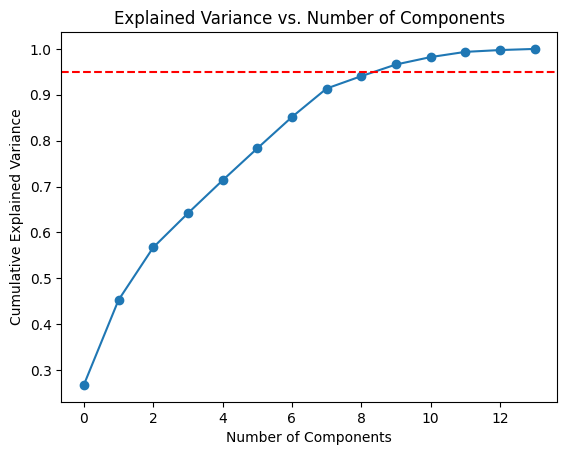

In [40]:
# Create a PCA instance
pca = PCA()

# Fit PCA on the standardized data
pca.fit(user_df[num_columns])

# Plot the explained variance ratio, we are going to look at the graph to get the best n_components to retain
plt.plot(np.cumsum(pca.explained_variance_ratio_),marker='o')
plt.axhline(y=0.95, linestyle="--",color="red") # plot a line at 0.95
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.show()

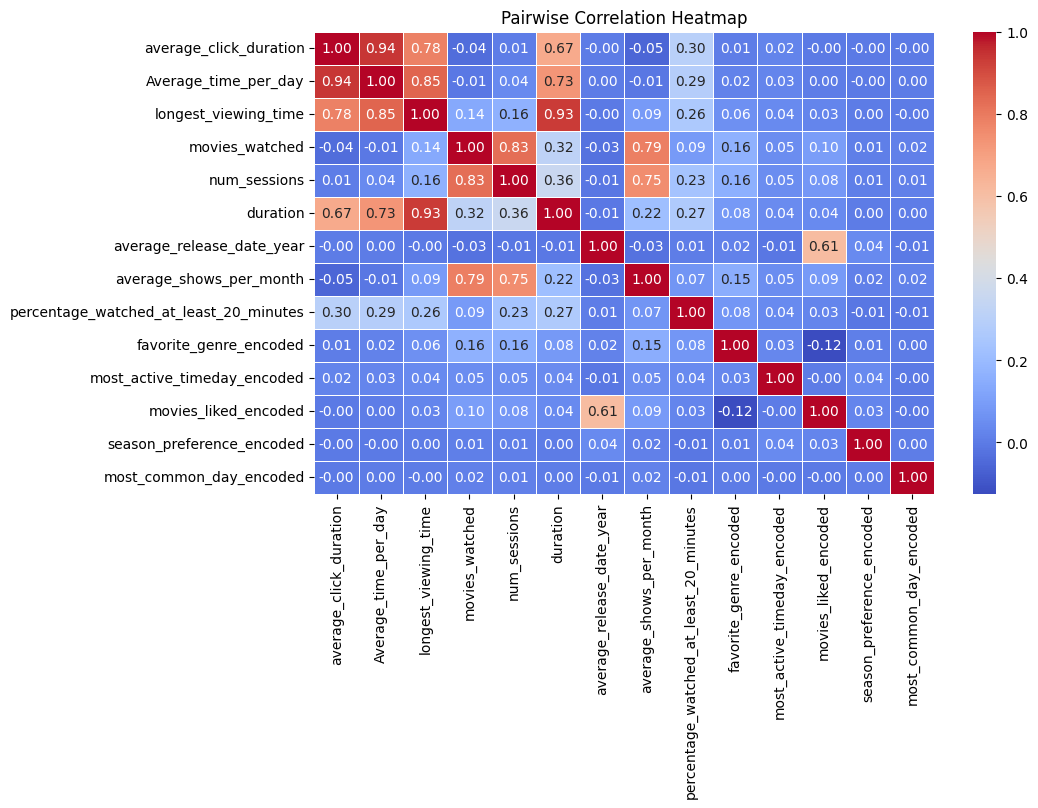

In [42]:
# Assuming df is your DataFrame
# Include only numerical columns for correlation analysis
numerical_columns = user_df.select_dtypes(include=["float64", "int64"]).columns
df_numeric = user_df[numerical_columns]

# Calculate pairwise correlation
correlation_matrix = df_numeric.corr()

# Plot a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Pairwise Correlation Heatmap")
plt.show()

The ECV plot shows how much of the total variance in the data is captured as number of components increase. A common rule of thumb is to retain the number of PCs that capture at least 95% of the total variance. For this reason we believe that 8 n_components is good enough

In [43]:
# Set the number of components you want to retain
n = 8

# Create a PCA instance with the specified number of components
pca = PCA(n_components=n)

# Fit and transform the data
pca_result = pca.fit_transform(user_df[num_columns])

# Create a DataFrame with the transformed data
pca_columns = [f"Column{i}" for i in range(1, n + 1)]
pca_df = pd.DataFrame()
for i in range(n):
    pca_df[pca_columns[i]] = pca_result[:, i]

# Concatenate the PCA results with the rest of the user_df
pca_df = pd.concat([user_df.drop(columns=num_columns), pca_df], axis=1)

# Display the resulting DataFrame
pca_df.head()

,user_id,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,00004e2862,-1.165613,-0.669571,1.986730,-0.288668,1.600853,0.684420,-1.327391,0.150878
1,000052a0a0,0.899662,3.611785,-0.012029,0.970702,0.424260,1.363689,-0.188142,-0.949612
2,000090e7c8,-0.984431,-0.303364,-0.735199,0.205857,-1.693285,-1.204173,-1.462705,1.519648
3,000118a755,-0.823008,0.033409,4.775433,-1.360703,-1.185753,0.829840,0.246546,0.966138
4,000296842d,-0.005689,0.912565,-0.961849,-1.915009,-0.694761,0.438038,-0.137189,0.475072


In [44]:
# Save df
pca_df.to_csv("pca_df.csv", index=False)

### 2.3 Clustering!

1. Implement the K-means clustering algorithm (**not** ++: random initialization) using MapReduce. We ask you to write the algorithm from scratch following what you learned in class.

---

In the following steps we are going to provide the code we used inside a PySpark application using the AWS EMR service. The enviroment is exactly the same we saw in the Lab.

After successfully connecting to the cluster we configured our PySpark environment so we were able to install new packages.

In [ ]:
%%configure -f
{
   "conf": {
       "spark.pyspark.python": "python3",
       "spark.pyspark.virtualenv.enabled": "true",
       "spark.pyspark.virtualenv.type":"native",
       "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
   }
}

We installed the `scikit-learn` library because we are going to use the function `silhouette_score` later to determine the optimal `k`.

In [ ]:
sc.install_pypi_package("scikit-learn")

#### Import Libraries and Modules

In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score

We loaded our csv file that contains the calculated PCA components from the previous step, which we stored in a S3 bucket, into a Spark DataFrame.

In [ ]:
# S3 path of our csv file with the calculated PCA components
s3_path = "s3://aws-logs-434589205080-us-east-1/elasticmapreduce/j-1MMORI1AMH6HG/data/pca_df.csv"

# Read data into a Spark DataFrame
df = spark.read.csv(s3_path, header=True, inferSchema=True)

# Extract the only the PCA columns as the data points
data_rdd = df.rdd.map(lambda row: np.array(row[1:]))

In the following we implemented our own K-means clustering algorithm using MapReduce:

1. Specifing number of clusters `k`
2. Initializing centroids by first shuffling the dataset and then randomly selecting `k` data points for the centroids without replacement
3. Computing the sum of the squared distance between data points and all centroids (inside `map_function`)
4. Assigning each data point to the closest centroid (inside `map_function`)
5. Computing the new centroids by taking the average of all data points that belong to each cluster (part of `reduce_function`)
6. Keep iterating until there is only a little change to the centroids or until we reach `max_iterations`

In [ ]:
def map_function(point, centroids):
    
    # Retrieve the centroid that is the closest to the given point
    nearest_centroid = np.argmin([np.linalg.norm(point-centroid) for centroid in centroids])
    
    return (nearest_centroid, [point])


def reduce_function(point1, point2):
    return point1+point2


def kmeans(data_rdd, k):

    # Shuffle the data
    shuffled_data_rdd = data_rdd.sortBy(lambda x: np.random.rand())

    # Select four random data points as the initial centroids
    initial_centroids = shuffled_data_rdd.takeSample(False, k)

    # Number of maximum iterations
    max_iterations = 10

    # Stop after max_iters if algorithm didn't converge before
    for iteration in range(max_iterations):

        # Execute Map step
        mapped_rdd = shuffled_data_rdd.map(lambda point: map_function(point, initial_centroids))

        # Execute Reduce step
        reduced_rdd = mapped_rdd.reduceByKey(lambda x, y: reduce_function(x, y))

        # Collect the results
        result = reduced_rdd.collect()

        # Extract new centroids from the results
        new_centroids = [np.mean(cluster_points, axis=0) for _, cluster_points in result]

        # Check if algorithm converged
        if np.allclose(new_centroids, initial_centroids, rtol=0.1):
            break

        # Update centroids and continue if algorithm didn't converge
        initial_centroids = new_centroids
    
    return mapped_rdd, initial_centroids

2. Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

---

We decided on using the Elbow Method by calculating the Within-Cluster Sum of Square (WCSS) between each point and in addition on using the Average Silhouette Method by calculating the Average Silhouette Score of all observations.

For this we ran our K-means algorithm for `k` between 2 and 10 and calculated the WCSS and Average Silhouette Score for every `k`. 

In [ ]:
# Create empty dictionaries to save the WCSS and Average Silhouette Score for every k
wcss_dict = {key: None for key in range(2, 11)}
ass_dict = {key: None for key in range(2, 11)}

# Iterate through k from 2 to 10
for k in range(2, 11):
    
    # Run K-means algorithm on the data obtained from the dimensionality reduction
    mapped_rdd, centroids = kmeans(data_rdd, k)
    
    # Collect the results
    results = mapped_rdd.collect()

    # Extracting points and labels from the data
    points = [point[1][0] for point in results]
    labels = [point[0] for point in results]

    # Calculate the total WCSS and Average Silhouette Score
    wcss_dict[k] = sum(np.min(np.square(np.array(points)-centroid), axis=1).sum() for centroid in centroids)
    ass_dict[k] = silhouette_score(np.array(points), labels)

In the following we present our results obtained from our AWS EMR Cluster in a graphical representation:

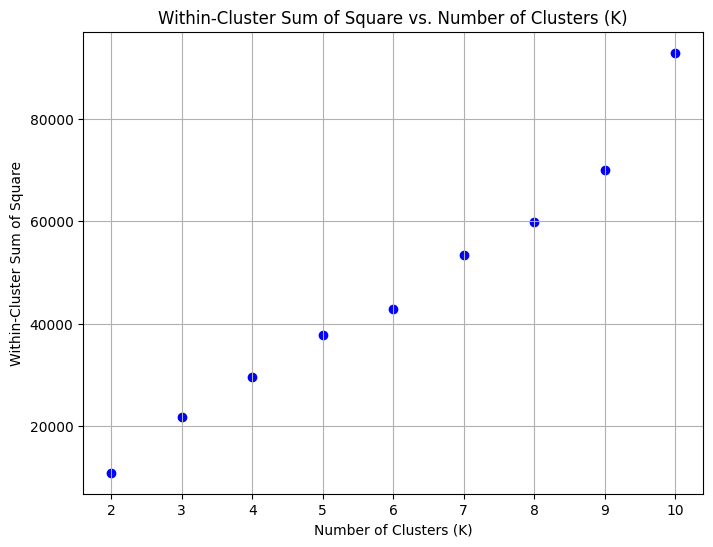

In [45]:
wcss_dict = {2: 10896.966838054857,
             3: 21773.209725789675,
             4: 29589.53845898541,
             5: 37748.23648627326,
             6: 42852.138836511076,
             7: 53409.682300788074,
             8: 59830.654563452204,
             9: 70006.57187045665,
             10: 92859.74267949654}

ass_dict = {2: 0.1761768369836495,
            3: 0.20007578011166785,
            4: 0.22155731664158781,
            5: 0.16358278755554498,
            6: 0.13373917065230106,
            7: 0.13974701732603312,
            8: 0.12187232374476131,
            9: 0.11732787364085119,
            10: 0.1262738721487958}

# Extracting k values and corresponding WCSS and Average Silhouette Score
k = list(wcss_dict.keys())
wcss = list(wcss_dict.values())
ass = list(ass_dict.values())

# Plotting the scatter plot for WCSS
plt.figure(figsize=(8, 6))
plt.scatter(k, wcss, color="blue", marker="o")
plt.title("Within-Cluster Sum of Square vs. Number of Clusters (K)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Square")
plt.grid(True)
plt.show()

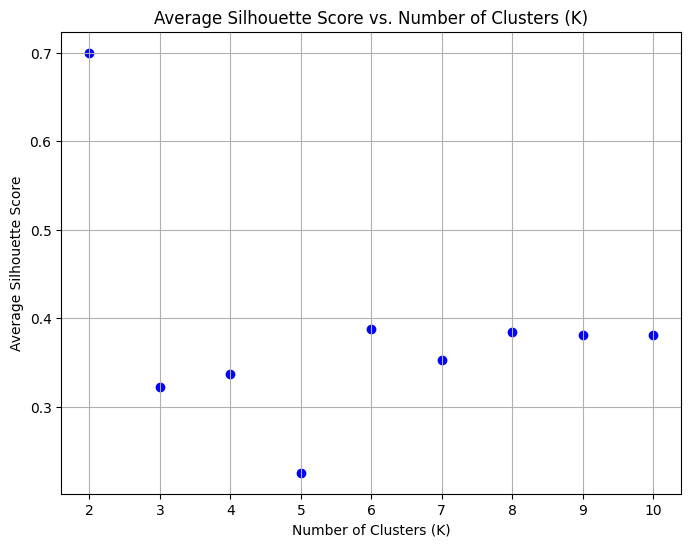

In [67]:
# Plotting the scatter plot for Average Silhouette Score
plt.figure(figsize=(8, 6))
plt.scatter(k, ass, color="blue", marker="o")
plt.title("Average Silhouette Score vs. Number of Clusters (K)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Average Silhouette Score")
plt.grid(True)
plt.show()

We based our decision on the trade-off between minimizing the Within-Cluster Sum of Squares (WCSS) and maximizing the Average Silhouette Score. After looking at both plots we chose **5** to be our optimal `k`.

3. Run the algorithm on the data obtained from the dimensionality reduction.

---

After we determined what our optimal `k` is we ran our K-means algorithm with it and saved the results in a csv stored in our S3 bucket.

In [ ]:
# Choice of optimal k
k = 5

# Run K-means algorithm on the data obtained from the dimensionality reduction
mapped_rdd, centroids = kmeans(data_rdd, k)

# Collect the final result
clusters = mapped_rdd.map(lambda x: [int(x[0])] + [float(i) for i in x[1][0]])

# S3 path of our output path
s3_path = "s3a://aws-logs-434589205080-us-east-1/elasticmapreduce/j-1MMORI1AMH6HG/data/kmean_clusters"

# Save clusters inside a Spark DataFrame
columns = ["Cluster", "Column1", "Column2", "Column3", "Column4", "Column5", "Column6", "Column7", "Column8"]
df = spark.createDataFrame(clusters, columns)

# Save DataFrame into a csv stored in S3
df.coalesce(1).write.mode("overwrite").option("header", "true").csv(s3_path)

In the following we present our output from the previous step:

In [46]:
# Path from the results of the previous step
file_path = "/Users/andre/Data Science/Semester_1/ADM/HW4/kmeans_output.csv"

# Read data into a Pandas DataFrame
kmean_result = pd.read_csv(file_path, delimiter=",", encoding="utf-8")

kmean_result.head(10)

,Cluster,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,0,-0.314218,0.078452,-0.787818,-0.626598,-0.099970,-0.712491,1.005679,0.682209
1,0,-1.094678,-0.633046,2.081676,-1.207061,-0.666255,0.750065,0.535179,0.799999
2,2,0.342774,0.457623,-0.413821,1.894085,0.827303,-0.539257,0.740199,-0.982565
3,1,-1.100629,-0.538271,-0.679155,0.741659,-1.399541,0.079248,-0.679099,0.943983
4,4,1.489099,2.616993,-0.214333,-2.749515,-1.201140,-1.677618,-1.565123,1.546609
5,0,-0.954847,-0.248820,-1.020751,-1.994124,-0.624438,0.438772,-0.208077,1.011556
6,1,-1.185895,-0.738142,3.135912,-0.202316,0.227186,1.669284,-1.215323,0.038775
7,1,-0.772161,-0.434182,-1.189127,-0.232555,-1.032604,1.387606,-1.047735,-0.985219
8,1,-1.090914,-0.482512,-0.918706,0.225201,1.263776,-0.358393,-0.986670,0.608195
9,4,0.815133,4.175315,2.187273,0.247203,1.738859,1.510255,-1.053685,-0.047600


In [47]:
kmean_result["Cluster"].value_counts()

Cluster
1    62884
0    43949
2    41623
4    10160
3     3302
Name: count, dtype: int64

4. Implement **K-means++** from scratch and explain the differences with the results you got earlier.

---

To modify our K-means to a K-means++ algorithm we added a function that randomly chooses the first centroid and then determines the others remaining centroids by calculating the squared distance to the nearest existing centroid of each point and the probability of selecting the next centroid. The next centroid is chosen randomly from the data points based on the calculated probabilities.

In [ ]:
def choose_centroids(data_rdd, k):
    
    centroids = []
    
    # Randomly choose the first centroid
    centroids.append(data_rdd.takeSample(False, 1)[0])
    
    # Determine the remaining k-1 centroids
    for _ in range(1, k):
        
        # Calculate the squared distance to the nearest existing centroid of each point
        distances = data_rdd.map(lambda point: (point, np.min([np.linalg.norm(point-centroid)
                                                               for centroid in centroids])**2))
        
        # Normalize the distances and select the next centroid
        total_distance = distances.map(lambda x: x[1]).sum()
        probabilities = distances.map(lambda x: (x[0], x[1]/total_distance))
        next_centroid = probabilities.takeSample(False, 1)[0][0]
        
        centroids.append(next_centroid)
    
    return centroids


def kmeans_pp(data_rdd, k):
    
    # Initializing centroids using the k-means++ approach
    initial_centroids = choose_centroids(data_rdd, k)

    # Number of maximum iterations
    max_iterations = 10

    # Stop after max_iters if algorithm didn't converge before
    for iteration in range(max_iterations):

        # Execute Map step
        mapped_rdd = data_rdd.map(lambda point: map_function(point, initial_centroids))

        # Execute Reduce step
        reduced_rdd = mapped_rdd.reduceByKey(lambda x, y: reduce_function(x, y))

        # Collect the results
        result = reduced_rdd.collect()

        # Extract new centroids from the results
        new_centroids = [np.mean(cluster_points, axis=0) for _, cluster_points in result]

        # Check if algorithm converged
        if np.allclose(new_centroids, initial_centroids, rtol=0.1):
            break

        # Update centroids and continue if algorithm didn't converge
        initial_centroids = new_centroids
    
    return mapped_rdd, initial_centroids

Again, we ran our now K-means++ algorithm for `k` between 2 and 10 and calculated the WCSS and Average Silhouette Score for every `k`.

In [ ]:
# Create empty dictionaries to save the WCSS and Average Silhouette Score for every k
wcss_dict = {key: None for key in range(2, 11)}
ass_dict = {key: None for key in range(2, 11)}

# Iterate through k from 2 to 10
for k in range(2, 11):
    
    # Run K-means++ algorithm on the data obtained from the dimensionality reduction
    mapped_rdd, centroids = kmeans_pp(data_rdd, k)
    
    # Collect the results
    results = mapped_rdd.collect()

    # Extracting points and labels from the data
    points = [point[1][0] for point in results]
    labels = [point[0] for point in results]

    # Calculate the total WCSS and Average Silhouette Score
    wcss_dict[k] = sum(np.min(np.square(np.array(points)-centroid), axis=1).sum() for centroid in centroids)
    ass_dict[k] = silhouette_score(np.array(points), labels)

In the following we present our results obtained from our AWS EMR Cluster in a graphical representation:

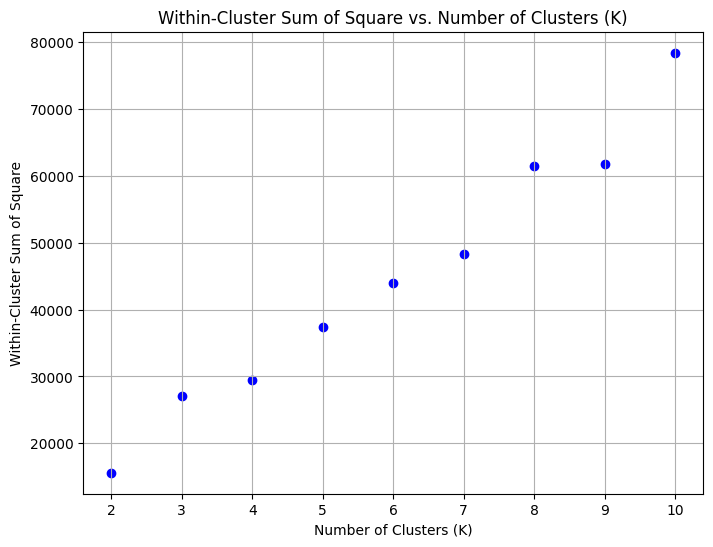

In [71]:
wcss_dict = {2: 15599.531511980118,
             3: 27087.817819876473,
             4: 29522.19583274651,
             5: 37384.90056830678,
             6: 43933.28509788384,
             7: 48294.07282084042,
             8: 61423.92431295851,
             9: 61805.098454310486,
             10: 78447.42298425805}

ass_dict = {2: 0.4849019280465204,
            3: 0.4143442772737603,
            4: 0.22149899218952904,
            5: 0.14718058811418538,
            6: 0.1623778721575989,
            7: 0.11055824627857214,
            8: 0.12561803061399893,
            9: 0.12249551968114035,
            10: 0.1196563841551888}

# Extracting k values and corresponding WCSS and Average Silhouette Score
k = list(wcss_dict.keys())
wcss = list(wcss_dict.values())
ass = list(ass_dict.values())

# Plotting the scatter plot for WCSS
plt.figure(figsize=(8, 6))
plt.scatter(k, wcss, color="blue", marker="o")
plt.title("Within-Cluster Sum of Square vs. Number of Clusters (K)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Square")
plt.grid(True)
plt.show()

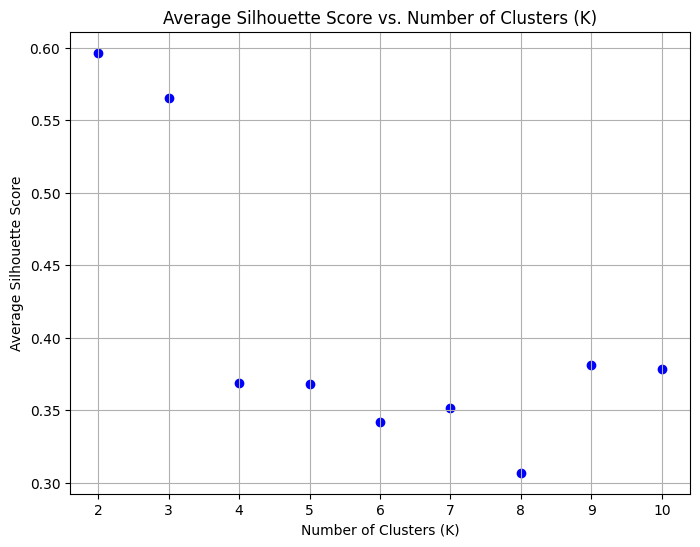

In [80]:
# Plotting the scatter plot for Average Silhouette Score
plt.figure(figsize=(8, 6))
plt.scatter(k, ass, color="blue", marker="o")
plt.title("Average Silhouette Score vs. Number of Clusters (K)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Average Silhouette Score")
plt.grid(True)
plt.show()

After we determined what our optimal `k` is we ran our K-means++ algorithm with it and saved the results in a csv stored in our S3 bucket.

In [ ]:
# Set k
k = 6

# Run K-means++ algorithm on the data obtained from the dimensionality reduction
mapped_rdd, centroids = kmeans_pp(data_rdd, k)

# Collect the final result
clusters = mapped_rdd.map(lambda x: [int(x[0])] + [float(i) for i in x[1][0]])

# S3 path of our output path
s3_path = "s3a://aws-logs-434589205080-us-east-1/elasticmapreduce/j-1MMORI1AMH6HG/data/kmean_pp_clusters"

# Save clusters inside a Spark DataFrame
columns = ["Cluster", "Column1", "Column2", "Column3", "Column4", "Column5", "Column6", "Column7", "Column8"]
df = spark.createDataFrame(clusters, columns)

# Save DataFrame into a csv stored in S3
df.coalesce(1).write.mode("overwrite").option("header", "true").csv(s3_path)

In [75]:
# Path from the results of the previous step
file_path = "/Users/andre/Data Science/Semester_1/ADM/HW4/kmeans_pp_output.csv"

# Read data into a Pandas DataFrame
kmean_pp_result = pd.read_csv(file_path, delimiter=",", encoding="utf-8")

kmean_pp_result.head(10)

,Cluster,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,0,-1.165613,-0.669571,1.986730,-0.288668,1.600853,0.684420,-1.327391,0.150878
1,1,0.899662,3.611785,-0.012029,0.970702,0.424260,1.363689,-0.188142,-0.949612
2,2,-0.984431,-0.303364,-0.735199,0.205857,-1.693285,-1.204173,-1.462705,1.519648
3,0,-0.823008,0.033409,4.775433,-1.360703,-1.185753,0.829840,0.246546,0.966138
4,4,-0.005689,0.912565,-0.961849,-1.915009,-0.694761,0.438038,-0.137189,0.475072
5,2,-0.329726,-0.115326,-0.535135,0.997538,-0.417031,0.098858,-0.234798,-0.047652
6,4,-0.911728,-0.141998,-0.779867,-0.728754,-1.023096,-0.389736,0.790342,1.354880
7,4,-1.039242,-0.445077,-0.897734,-1.703715,1.459382,0.260690,0.258289,0.615244
8,0,-1.145987,-0.710791,1.483591,-0.893796,1.416356,0.548795,1.015498,0.445514
9,2,-1.187555,-0.711308,-0.861320,1.125711,-1.193039,0.977747,-0.118230,0.542278


In [76]:
kmean_pp_result["Cluster"].value_counts()

Cluster
2    46203
0    34137
4    33463
1    28565
5    12346
3     7204
Name: count, dtype: int64

The result is actually pretty close to the one from the K-mean algorithm with one more cluster. We guess that the random selected centroids provided a pretty good solution because the K-mean++ should provide in general the better results due to the idea of spreading the initial centroids apart to improve the convergence and quality of the final clusters.

5. Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

---

Asking ChatGPT we go the following answer:

Certainly! Let's consider the recommendation and choice of an alternative clustering algorithm. One interesting option is the Spectral Clustering algorithm. **Spectral Clustering** has gained popularity for its ability to capture complex cluster structures and work well on non-convex shapes.

### Recommendation:
I recommend trying Spectral Clustering for your clustering task. It is particularly useful when dealing with data that may have non-linear relationships and when clusters have different shapes and sizes.

### Explanation:
Spectral Clustering works by transforming the data into a lower-dimensional space using the eigenvectors of a similarity matrix. This can be beneficial when dealing with intricate cluster structures that may not be well-separated in the original feature space. It's also effective in handling data with varying densities and shapes.

### Implementation and Comparison:
1. Implement Spectral Clustering:
    - You can use the implementation provided in the scikit-learn library. It offers a flexible and efficient implementation. 
2. Run it on Your Data:
    - Apply Spectral Clustering to your dataset and observe the cluster assignments.
3. Compare Results with K-Means:
    - Compare the results obtained from Spectral Clustering with those from K-Means. Note any differences in the cluster structures and assignments.
    
### Evaluation:
Evaluate the performance of both algorithms based on your specific goals and the characteristics of your data. Consider aspects such as the shapes of clusters, density variations, and the overall quality of cluster assignments.

### My Opinion:
The choice between K-Means and Spectral Clustering depends on the nature of your data. K-Means is simpler and faster but assumes convex-shaped clusters. Spectral Clustering is more flexible and can handle a wider range of cluster shapes, making it a good choice for complex datasets.

### Implementation (Spectral Clustering):
Here's a simplified example using scikit-learn:

```python
from sklearn.cluster import SpectralClustering
import numpy as np

# Assuming X is your data
# X = ...

# Specify the number of clusters (K)
k = 3

# Create a SpectralClustering instance
spectral_clustering = SpectralClustering(n_clusters=k, random_state=42)

# Fit the model and obtain cluster assignments
labels_spectral = spectral_clustering.fit_predict(X)
```

Evaluate the results, compare them with K-Means, and analyze which algorithm performs better based on your criteria.

Feel free to proceed with this approach and share the results or ask for further assistance!

---

We decided on going forward with Spectral Clustering for the reasons ChatGTP stated.

In [77]:
%%capture

# Set k
k = 6

# Local path to your CSV file
local_path = "/Users/andre/Data Science/Semester_1/ADM/HW4/pca_df.csv"

# Read data into a Pandas DataFrame
df = pd.read_csv(local_path)

# Extract the last four columns as the data points
data = df.iloc[:, 1:].values

# Set batch size
batch_size = 1000

# Initialize an empty list to store the results
result_list = []

# Create a Spectral Clustering instance
spectral_clustering = SpectralClustering(n_clusters=k, random_state=42)

# Iterate through the data in mini batches
for i in range(0, data.shape[0], batch_size):
    batch_data = data[i:i+batch_size]

    # Fit and predict on the current mini batch
    labels_batch = spectral_clustering.fit_predict(batch_data)

    # Combine cluster labels with original coordinates
    batch_result = np.hstack((labels_batch.reshape(-1, 1), batch_data))
    
    # Append the results to the list
    result_list.append(batch_result)

# Concatenate results
final_result = np.concatenate(result_list, axis=0)

# Read data into a Pandas DataFrame
columns = ["Cluster", "Column1", "Column2", "Column3", "Column4", "Column5", "Column6", "Column7", "Column8"]
spectral_lustering_result = pd.DataFrame(final_result, columns=columns)

In [78]:
spectral_lustering_result["Cluster"].value_counts()

Cluster
0.0    133116
2.0     20311
3.0      4131
5.0      1953
1.0      1319
4.0      1088
Name: count, dtype: int64

**Conclusion:** It seems like that Spectral Clustering is not suited for the shape of our dataset and KNN actually performs better.

### 2.4 Analysing your results! --

You are often encouraged to explain the main characteristics that your clusters have. The latter is called the Characterizing Clusters step. Thus, follow the next steps to do it:

1. Select 2-3 variables you think are relevant to identify the cluster of the customer. For example, Time_Day, Average Click Duration, etc.

2. Most of your selected variables will be numerical (continuous or discrete), then categorize them into four categories.

3. With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.

4. Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100. The sample example for clustering with K = 4 and Time_Day variable:

<img src="image.png" alt="Image" width="300"/>

5. Interpret the results for each pivot table.

6. Use any known metrics to estimate clustering algorithm performance (how good are the clusters you found?). Comment on the results obtained.

In [20]:
############
### CODE ###
############

## 3. Bonus Question
We remind you that we consider and grade the bonuses only if you complete the entire assignment.

[Density-based clustering](https://wires.onlinelibrary.wiley.com/doi/epdf/10.1002/widm.30) identifies clusters as regions in the data space with high point density that are separated from other clusters by regions of low point density. The data points in the separating regions of low point density are typically considered noise or outliers. Typical algorithms that fall into this category are [OPTICS](https://dl.acm.org/doi/pdf/10.1145/304181.304187) and [DBSCAN](https://cdn.aaai.org/KDD/1996/KDD96-037.pdf).

1. Ask ChatGPT (or any other LLM tool) to list three algorithms for Density-Based Clustering. Choose one and use it on the same dataset you used in 2.3. Analyze your results: how different are they from the centroid-based version?

**Note**: You can implement your algorithm from scratch or use the one implemented in the scikit-learn library; the choice is up to you!

---

Asking ChatGPT we go the following answer:


Sure, Density-Based Clustering algorithms focus on identifying regions of high point density that are separated from one another by areas of lower point density. Here are three algorithms commonly used for density-based clustering:

1. **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**: This algorithm defines clusters as continuous regions of high point density. It groups together data points that are close to each other and have a sufficient number of neighbors, while marking data points in sparser regions as outliers.

2. **OPTICS (Ordering Points To Identify Clustering Structure)**: OPTICS is an extension of DBSCAN. It creates a reachability plot, ordering data points based on their density and distance to neighboring points. This allows for the identification of clusters and noise in a hierarchical manner.

3. **HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)**: HDBSCAN is another extension of DBSCAN, but it builds a hierarchy of clusters with different levels of granularity. It allows for the identification of clusters of varying shapes and densities.

Now, let's choose one of these algorithms (let's say DBSCAN) and apply it to the dataset you used in 2.3. Analyze the results to see how they differ from the centroid-based version.

```python

# Assuming 'X' is your dataset
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Instantiate DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit and predict clusters
labels_dbscan = dbscan.fit_predict(X)

# Visualize the results
plt.scatter(X[:, 0], X[:, 1], c=labels_dbscan, cmap='viridis', marker='o', edgecolor='black')
plt.title('DBSCAN Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

```

This code assumes a 2D dataset. You might need to adjust the parameters like `eps` (maximum distance between two samples for one to be considered as in the neighborhood of the other) and `min_samples` (the number of samples in a neighborhood for a point to be considered as a core point). Analyze how the results differ from the centroid-based version, considering the clusters' shapes, ability to handle noise, and overall performance.

---

We decided to try to implement the chosen algorithm DBSCAN.

In [54]:
# Convert your list of lists to a Numpy array
X = np.array(data)

# Instantiate DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=500)

# Fit and predict clusters
labels_dbscan = dbscan.fit_predict(X)

In [55]:
# Get unique values and their counts
unique_values, counts = np.unique(labels_dbscan, return_counts=True)

# Print unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: -1, Count: 155076
Value: 0, Count: 726
Value: 1, Count: 1590
Value: 2, Count: 1026
Value: 3, Count: 817
Value: 4, Count: 841
Value: 5, Count: 377
Value: 6, Count: 500
Value: 7, Count: 461
Value: 8, Count: 504


**Conclusion:** DBSCAN is also not suitable at all for our dataset because it identifies almost all points as outliers.

## 4. Command Line Question (CLQ)

Here is another command line question to enjoy. We previously stated that using the command line tools is a skill that Data Scientists must master.

In this question, you should use any command line tool that you know to answer the following questions using the same dataset that you have been using so far:

- What is the most-watched Netflix title?
- Report the average time between subsequent clicks on Netflix.com
- Provide the ID of the user that has spent the most time on Netflix

Important note: You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable. Please run the script and include a screenshot of the <u>output</u> in the notebook for evaluation.

---

For this task we use the AWK language, which is (definition from the Wiki page) a data-driven scripting language consisting of a set of actions to be taken against streams of textual data – either run directly on files or used as part of a pipeline – for purposes of extracting or transforming text, such as producing formatted reports.

#### Short data analysis

- The cvs has 7 columns (datetime,duration,title,genres,release_date,movie_id,user_id) <br/>plus a index column, and this first row is called the "header".
- The datetime column is not sorted, but is well formatted since <br/>every entry has the "YYYY-MM-DD HH:MM:SS" format.
- The duration column "shows how long it was (in seconds) until that user clicked on another URL. <br/>A watch time of zero seconds means they visited the page but instantly clicked away".<br/> We can also find negative duration values in the dataset, which have to be taken care of.

#### What is the most-watched Netflix title?

- cat "file path" is used to read the cvs file, so that we can work on it.<br/> 
We need to do something similar to a "groupby" in pandas,<br/>
so we select only the positive durations in the column (notice that {\\$2>0} filters the positive values) and sum the durations <br/>
for every unique movie_id ({(\\$NF-1)} is the column with the movie_id).

- (NF-1) is used to select the second-to-last column, since NF stands for number of fields in a row.<br/>
This will give us the total watchtime for every unique movie_id in the dataset. The last thing to do is to sort the elements and print the first one. <br/>The result is the most watched title on Netflix (so the movie that people have spent the most amount of time watching).

#### Report the average time between subsequent clicks on Netflix.com

First of all, we notice that the "datetime" column is not sorted, so we use the sort function to sort like this. <br/>
We give priority to year, month, day and then time - in ascending order - <br/>
Use the following command: sort -t, -k2,2 -k3,3, which sorts the second and third fields of the second column.<br/>
(Here we show just a couple of lines from the sorted cvs to see how it works)

- 2017-01-01 00:02:21
- 2017-01-01 00:04:26
- 2017-01-01 00:04:47

We can use the mktime function to compute the difference (in seconds, but the conversion in hours is straightforward) <br/>in time between two rows. The code also takes into account the negative time difference, like in this case:

- 2017-01-01 23:51:31,
- 2017-01-02 00:03:20,

If the value is negative just sum (86400 + diff), namely the amount of seconds in a day and the negative difference.<br/>
Finally, print the average, which is the sum of time differences divided by the number of rows without the header <br/>(and -1 since from N rows we get N-1 time differences).

#### Provide the ID of the user that has spent the most time on Netflix

The idea is exactly the same as question one, but instead of grouping by movie_id, we group by user_id, and then sum the durations. <br/>
We still consider the positive values in the duration column. <br/>
This time we use the last column (NF) which has all the user_id. <br/>
This gives us the id of the user that has the highest watchtime on Netflix.

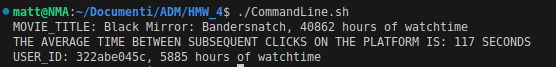

In [18]:
display(Image(filename="CommandLine_results.png", embed=True))

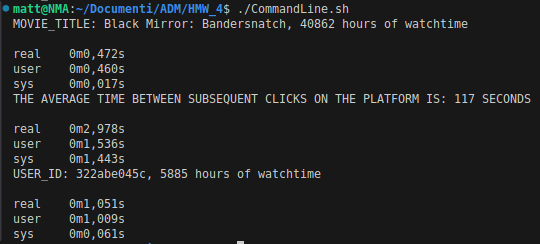

In [19]:
display(Image(filename="CommandLine_results_time.png", embed=True))

## 5. Algorithmic Question (AQ)

Federico studies in a demanding university where he has to take a certain number $N$ of exams to graduate, but he is free to choose in which order he will take these exams. Federico is panicking since this university is not only one of the toughest in the world but also one of the weirdest. His final grade won't depend at all on the mark he gets in these courses: there's a precise evaluation system.

He was given an initial personal score of $S$ when he enrolled, which changes every time he takes an exam: now comes the crazy part. He soon discovered that every of the $N$ exams he has to take is assigned a mark $p$. Once he has chosen an exam, his score becomes equal to the mark $p$, and at the same time, the scoring system changes:

- If he takes an "easy" exam (the score of the exam being less than his score), every other exam's mark is increased by the quantity $S-p$.
- If he takes a "hard" exam (the score of the exam is greater than his score), every other exam's mark is decreased by the quantity $p-S$.

So, for example, consider $S=8$ as the initial personal score. Federico must decide which exam he wants to take, being $[5,7,1]$ the marks list. If he takes the first one, being $5<8$ and $8-5=3$, the remaining list now becomes $[10,4]$, and his score is updated as $S=5$.

In this chaotic university where the only real exam seems to be choosing the best way to take exams, you are the poor student advisor who is facing a long queue of confused people who need some help. Federico is next in line, and he comes up in turn with an inescapable question: he wants to know which is the highest score possible he could get.

#### a) Fortunately, you have a computer app designed by a brilliant student. Federico wants you to show him the code which this app is based on because he wants to do paid counseling for other desperate students: in a recursive fashion, the helped helps the helpable.

Let's implement a recursive function that explores all possible combinations of a list of *marks* (the exams the student can choose) and calculates the maximum score the student can achieve among all combinations.

So, the function will take **marks** as the list of exams,

**S** as the initial score of the student,

**n** as the length of marks,

**s** as an empty list that we will use to store the results of various combinations.

In [1]:
def recursive_function(marks, S, n, s):
    
    # if n is zero, the function adds S to the list s and returns S.
    if n == 0: 
        s.append(S)
        return S
    
    # initialize the variable with the current value of S
    max_s = S 
    
    # define a loop that iterates over all indices of marks from 0 to n-1
    for i in range(n): 
        # create a copy of the marks list to avoid undesired modifications to the original list
        marks_temporary = marks[:]
        # assign the current value of marks to S_temporary
        S_temporary = marks[i]

        # if S is greater than S_temporary, the function calculates the difference S - S_temporary, 
        # removes the current element from marks_temporary, and updates all other elements by adding the difference
        if S > S_temporary:
            difference = S - S_temporary
            marks_temporary.pop(i)
            marks_temporary = [element + difference for element in marks_temporary]
                               
            # call the function recursively with the updated parameters
            max_s = recursive_function(marks_temporary, S_temporary, n - 1, s) 
            
        # if S_temporary is greater than S, calculate the difference as S_temporary - S, and 
        # update the marks_temporary list by subtracting the differences
        else:
            difference = S_temporary - S
            marks_temporary.pop(i)
            marks_temporary = [element - difference for element in marks_temporary]
                               
            # call the function recursively with the updated parameters
            max_s = recursive_function(marks_temporary, S_temporary, n - 1, s)

    return max(s)

Now, let's test it:

In [2]:
marks_list = [5, 7, 1]
initial_score = 8
result = recursive_function(marks_list, initial_score, len(marks_list), [])
print(f"{initial_score} \n{marks_list}")
print("Max score:", result)

8 
[5, 7, 1]
Max score: 11


In [3]:
marks_list = [18, 24, 21, 32, 27]
s = []
initial_score = 25
result = recursive_function(marks_list, initial_score, len(marks_list), s)
print(f"{initial_score} \n{marks_list}")
print("Max score:", result)

25 
[18, 24, 21, 32, 27]
Max score: 44


#### b) Federico is getting angry because he claims that your code is slow! Show him formally with a big-O notation that he is as crazy as this university!

We are performing **O(n!)** operations. This is because the recursive function iterates through all possible permutations of the elements in marks, and the total number of permutations is n!.

Given the very high computational complexity, the algorithm is highly inefficient.

#### c) If, unfortunately, Federico is right in the grip of madness, he will threaten you to optimize the code through a different approach. You should end this theater of the absurd by any means! (And again, formally prove that you improved time complexity)

To optimize the time complexity, we are seeking a different approach from the recursive one:
we can see that if the input has an odd length, the score does not depend on the initial score. 

Therefore, we can take the sorted list of marks, divide it into high_marks and low_marks, and subtract the sum of low_marks from the sum of high_marks. 
In case the marks list has an even length, we take the same result obtained previously and add it to the initial score.

In [5]:
def optimized_function(S, marks):

    # sort the array of scores in ascending order
    sorted_marks = np.sort(marks)

    # divide the sorted array in half, taking the low_marks and the high_marks
    low_marks = sorted_marks[:len(sorted_marks)//2]
    high_marks = sorted_marks[len(sorted_marks)//2:]

    # calculate the score by subtracting the sum of low_marks from the sum of high_marks
    score = sum(high_marks) - sum(low_marks)

    # if the length of the original array is even, add the initial score (S)
    if len(marks) % 2 == 0:
        score += S

    # return the calculated score
    return score

Let's test it:

In [8]:
marks_list = [5, 7, 1]
initial_score = 8
result = optimized_function(initial_score, marks_list)
print(f"{initial_score} \n{marks_list}")
print("Max score:", result)

8 
[5, 7, 1]
Max score: 11


In [9]:
marks_list = [18, 24, 21, 32, 27]
initial_score = 25
result = optimized_function(initial_score, marks_list)
print(f"{initial_score} \n{marks_list}")
print("Max score:", result)

25 
[18, 24, 21, 32, 27]
Max score: 44


In [10]:
marks_list = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
initial_score = 30
result = optimized_function(initial_score, marks_list)
print(f"{initial_score} \n{marks_list}")
print("Max score:", result)

30 
[13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
Max score: 205


Assuming n is the length of marks, we can say that:

In this version, the first operation is the sorting of marks, which has a computational cost of **O(nlogn)**.

Then the division of the array into high_marks and low_marks has an overall cost of **O(n)**.

The calculation of the score also has a cost of **O(n)**.

Therefore, the overall computational complexity will have a cost of **O(nlogn)**.

#### d) Ask chatGPT for a third (optimized) implementation and analyze again its time complexity. Be careful (and crafty) in defining the prompt, and challenge the machine in this coding question!

In [11]:
def chat_gpt(S, marks):
    # Convert the array to a NumPy array
    marks = np.array(marks)
    
    # Find the median value
    median = np.median(marks)
    
    # Divide the array based on the median value
    low_marks = marks[marks < median]
    high_marks = marks[marks >= median]

    # Calculate the sum of the lower and higher scores
    score = np.sum(high_marks) - np.sum(low_marks)

    # If the length of the original array is even, add the initial score (S)
    if len(marks) % 2 == 0:
        score += S

    # Return the calculated score
    return score

Let's test it:

In [12]:
marks_list = [5, 7, 1]
initial_score = 8
result = chat_gpt(initial_score, marks_list)
print(f"{initial_score} \n{marks_list}")
print("Max score:", result)

8 
[5, 7, 1]
Max score: 11


In [13]:
marks_list = [18, 24, 21, 32, 27]
initial_score = 25
result = chat_gpt(initial_score, marks_list)
print(f"{initial_score} \n{marks_list}")
print("Max score:", result)

25 
[18, 24, 21, 32, 27]
Max score: 44


In [14]:
marks_list = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
initial_score = 30
result = chat_gpt(initial_score, marks_list)
print(f"{initial_score} \n{marks_list}")
print("Max score:", result)

30 
[13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
Max score: 205


The computational complexity of this algorithm is **O(n)**, where n is the length of the array marks. This is because the runtime is dominated by operations of comparison and selection of elements based on the median value. The np.median function has a complexity of O(n) in the general case.

In this way, we have avoided sorting, which has a cost of O(nlogn), and have achieved a complexity of O(n).